# 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/DeeplearningPJ

/content/drive/MyDrive/DeeplearningPJ


# Model1: 선지 도메인 분류
## 참고사이트

https://gist.github.com/Lucia-KIM/165b8f13c007f83b4762ab436ea95610

https://byumm315.tistory.com/entry/%ED%95%9C%EA%B5%AD%EC%96%B4-%EB%89%B4%EC%8A%A4-%ED%86%A0%ED%94%BD-%EB%B6%84%EB%A5%98-1-I-am-yumida

## 필요한 패키지 설치

In [ ]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,082 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubunt

In [ ]:
!pip install -q tweepy==3.10

try:
    import konlpy
except:
    !pip install -q konlpy
    import konlpy

     |████████████████████████████████| 19.4 MB 4.8 MB/s 
     |████████████████████████████████| 465 kB 81.0 MB/s 


## 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

import matplotlib as mpl
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

## 데이터 불러오기

In [ ]:
data_raw = pd.read_excel("Dataset.xlsx", engine = "openpyxl")

In [ ]:
data1 = data_raw[['Testname','ChoiceText1']]
data2 = data_raw[['Testname','ChoiceText2']]
data3 = data_raw[['Testname','ChoiceText3']]
data4 = data_raw[['Testname','ChoiceText4']]
data1.columns = ['Testname','ChoiceText']
data2.columns = ['Testname','ChoiceText']
data3.columns = ['Testname','ChoiceText']
data4.columns = ['Testname','ChoiceText']

In [ ]:
data = pd.concat([data1,data2,data3,data4], axis=0)

In [ ]:
data = data.reset_index(drop=True,inplace=False)

## 데이터 전처리

In [ ]:
data = data.dropna()

In [ ]:
data.loc[(data['Testname'] == "건축기사"), 'Testname'] = 0 
data.loc[(data['Testname'] == "대기환경기사"), 'Testname'] = 1
data.loc[(data['Testname'] == "산업안전기사"), 'Testname'] = 2 
data.loc[(data['Testname'] == "소방설비기사"), 'Testname'] = 3 
data.loc[(data['Testname'] == "정보처리기사"), 'Testname'] = 4 

In [ ]:
def cleanText(readData):
    text = re.compile('[^ A-Za-z0-9가-힣]+')
    result = text.sub('', readData)
    return result

In [ ]:
for i in range(len(data)):
    data.iloc[i]['ChoiceText'] = cleanText(data.iloc[i]['ChoiceText'])

In [ ]:
#def isKorean(text):
#    hangul = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')  
#    result = hangul.findall(text)
#    return len(result)
#data_fin =pd.DataFrame({'Testname':[],'ChoiceText':[]})
#for i in range(len(data)):
#    if isKorean(data.iloc[i]['ChoiceText']) != 0:
#      data_fin = data_fin.append({'Testname':data.iloc[i]['Testname'],'ChoiceText':data.iloc[i]['ChoiceText']}, ignore_index=True)
#    else:
#      continue

In [ ]:
data

,Testname,ChoiceText
0,0,쇼룸
1,0,공사비가저렴하다
2,0,T자형
3,0,폐가식
4,0,상층침실하층침실
...,...,...
13795,4,특정하드웨어에종속되어특화된업무를서비스하기에적합하다
13796,4,SecureOS
13797,4,조건이복합되어있는곳의처리를시각적으로명확히식별하는데적합하다
13798,4,Logs


## train & test 데이터로 나누기

In [ ]:
x = data['ChoiceText']
y = data['Testname']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=10)

In [ ]:
train_data = pd.DataFrame({'document':x_train,
                             'label':y_train})

In [ ]:
test_data = pd.DataFrame({'document':x_test,
                             'label':y_test})

## 워드 임베딩



Word Tokenization

"모바일 게임은 재밌다 열심히 해서 만랩을 찍어야지~ ㅎㅎㅎ"
-> ['모바일', '게임', '은', '재밌다', '열심히', '하다', '만', '랩', '을', '찍다', '~', 'ㅎㅎㅎ']

In [ ]:
okt = Okt()

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # Okt() 이용해서 토큰화
    X_train.append(temp_X)

In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    X_test.append(temp_X)

Tokenizer를 이용하여 데이터에 있는 고유한 단어에 번호 할당

-> 정수 인덱싱 벡터화

-> 모든 문장의 단어 벡터 길이는 같아야하기 때문에, 같지 않은 경우 0으로 패딩해서 길이를 맞춘다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
total_count = len(tokenizer.word_index) # 단어의 수
vocab_size = total_count + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8957


In [ ]:
#threshold = 3
#total_count = len(tokenizer.word_index) # 단어의 수
#rare_count = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
#total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
#rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
#for key, value in tokenizer.word_counts.items():
#    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
#    if(value < threshold):
#        rare_count = rare_count + 1
#        rare_freq = rare_freq + value

#print('단어 집합(vocabulary)의 크기 :',total_count)
#print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
#print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
#print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2: 0번 단어는 패딩을 위한 토큰, 1번 단어는 OOV를 위한 토큰
#vocab_size = total_count - rare_count + 2
#print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'],dtype=np.int)
y_test = np.array(test_data['label'],dtype=np.int)

<ipython-input-27-a6268166a168>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.array(train_data['label'],dtype=np.int)
<ipython-input-27-a6268166a168>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in

In [ ]:
#drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

최대 길이 : 61
평균 길이 : 6.502264578222306


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

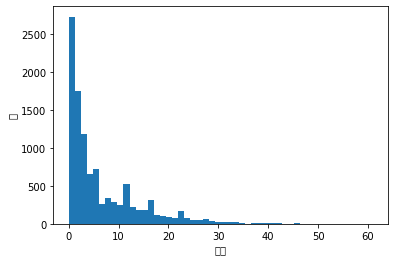

In [ ]:
print('최대 길이 :', max(len(l) for l in X_train))
print('평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('길이')
plt.ylabel('수')
plt.show()

In [ ]:
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

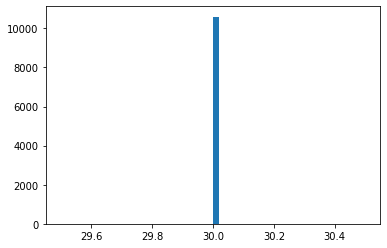

In [ ]:
# 패딩 작업이 잘 되었나 확인
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

## 데이터 레이블 균형 맞추기 & 데이터 증강

In [ ]:
pd.Series(y_train).value_counts()

0    2690
2    2531
4    2155
3    1868
1    1354
dtype: int64

In [ ]:
smote = SMOTE(random_state=0)
x_train_over,y_train_over = smote.fit_resample(X_train,y_train)

In [ ]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (10598, 30) (10598,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (13450, 30) (13450,)
SMOTE 적용 후 레이블 값 분포: 
 4    2690
1    2690
2    2690
3    2690
0    2690
dtype: int64


y 데이터 LSTM 입력을 위한 더미화

In [ ]:
y_train_over_fin = pd.get_dummies(y_train_over).values

## LSTM 모델

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model1 = Sequential()

model1.add(Embedding(vocab_size, 30))
model1.add(LSTM(128))
#model1.add(Dropout(0.2))
#model1.add(Dense(16))
#model1.add(Dropout(0.2))
model1.add(Dense(5, activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 30)          268710    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 350,763
Trainable params: 350,763
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model1.fit(x_train_over, y_train_over_fin, epochs=10, callbacks=[es, mc], batch_size=20, validation_split=0.3)

Epoch 1/10
470/471 [============================>.] - ETA: 0s - loss: 1.4127 - acc: 0.3994
Epoch 1: val_acc improved from -inf to 0.30632, saving model to best_model.h5
471/471 [==============================] - 13s 10ms/step - loss: 1.4122 - acc: 0.3999 - val_loss: 1.7860 - val_acc: 0.3063
Epoch 2/10
464/471 [============================>.] - ETA: 0s - loss: 0.7679 - acc: 0.7172
Epoch 2: val_acc improved from 0.30632 to 0.40768, saving model to best_model.h5
471/471 [==============================] - 3s 7ms/step - loss: 0.7653 - acc: 0.7182 - val_loss: 1.9240 - val_acc: 0.4077
Epoch 3/10
471/471 [==============================] - ETA: 0s - loss: 0.4105 - acc: 0.8588
Epoch 3: val_acc did not improve from 0.40768
471/471 [==============================] - 3s 7ms/step - loss: 0.4105 - acc: 0.8588 - val_loss: 2.2011 - val_acc: 0.4000
Epoch 4/10
468/471 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.9056
Epoch 4: val_acc did not improve from 0.40768
471/471 [===========

y_test 더미 변수화

In [ ]:
y_test_fin = pd.get_dummies(y_test).values

In [ ]:
print("\n 테스트 정확도: %.4f" %(model1.evaluate(X_test,y_test_fin)[1]))

37/37 [==============================] - 0s 3ms/step - loss: 0.9758 - acc: 0.6944

 테스트 정확도: 0.6944


# Model2: 문제 도메인 분류
## 참고사이트

https://hoit1302.tistory.com/159

https://velog.io/@jiyoung/Text-ClassificationKoBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0-%EC%BD%94%EB%93%9C

https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/nlp/ci-kobert-post/

## 필요한 패키지 설치

In [3]:
!pip install gluonnlp pandas tqdm   
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 22.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=619638 sha256=25b3e4dfaa31ff879357a049eccc2a450c9e7061e9936eceaeec8dcc8ee5c3b4
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pk

In [4]:
# 실행 후 필요시 런타임 재 실행
!pip install torch --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.1 MB/s eta 0:00:48tcmalloc: large alloc 1147494400 bytes == 0x38fda000 @  0x7f96b4c16615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 887.4 MB 1.7 kB/s 
     |████████████████████████████████| 849 kB 91.8 MB/s 
     |████████████████████████████████| 557.1 MB 9.3 kB/s 
     |████████████████████████████████| 317.1 MB 34 kB/s 
     |████████████████████████████████| 21.0 MB 85.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
ERROR: pip's dependency resol

In [5]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-9g4ppd25
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-9g4ppd25
     |████████████████████████████████| 129 kB 30.0 MB/s 
     |████████████████████████████████| 54.7 MB 121.4 MB/s 
     |████████████████████████████████| 4.5 MB 68.5 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x3a7bc000 @  0x7f65f9e92615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 881.9 MB 8.0 kB/s 
     |████████████████████████████████| 2.5 M

In [6]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-89j7_y73/kobert-tokenizer_52ea67b398a94586809b02f150028e31
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-89j7_y73/kobert-tokenizer_52ea67b398a94586809b02f150028e31
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=9b59ffb72c2a8faeb74b6d5a55630a71f95e553f580a44ae9f885ad5c84daeaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-drbq17nf/wheels/f7/cb/29/1a737fe71e5108dc30b04ea4a990f78ed271fa537aaf3fce7c
Successfully built kobert-tokenizer


## 패키지 불러오기

In [7]:
import pandas as pd
import re

from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert.utils import get_tokenizer

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cpu")

## 데이터 불러오기

In [8]:
data_raw = pd.read_excel("Dataset.xlsx", engine = "openpyxl")

In [9]:
data = data_raw[['Testname','MainText']]

## 데이터 전처리

In [10]:
data.loc[(data['Testname'] == "건축기사"), 'Testname'] = 0 
data.loc[(data['Testname'] == "대기환경기사"), 'Testname'] = 1
data.loc[(data['Testname'] == "산업안전기사"), 'Testname'] = 2 
data.loc[(data['Testname'] == "소방설비기사"), 'Testname'] = 3 
data.loc[(data['Testname'] == "정보처리기사"), 'Testname'] = 4 

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [11]:
for i in range(len(data)):
  if data.iloc[i]['MainText'][:2] in ['1.','2.','3.','4.','5.','6.','7.','8.','9.']:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][3:]
  elif data.iloc[i]['MainText'][:4] in ['100.']:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][5:]
  else:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][4:]

In [12]:
def cleanText(readData):
    text = re.compile('[^ A-Za-z0-9가-힣]+')
    result = text.sub('', readData)
    return result

In [13]:
for i in range(len(data)):
    data.iloc[i]['MainText'] = cleanText(data.iloc[i]['MainText'])

## train & test 데이터로 나누기

In [14]:
data_list = []
for ques, label in zip(data['MainText'], data['Testname'])  :
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [15]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

## 워드 임베딩

In [16]:
tokenizer = get_tokenizer()
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/drive/MyDrive/DeeplearningPJ/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/drive/MyDrive/DeeplearningPJ/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/DeeplearningPJ/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [18]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 30
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [19]:
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

## BERT 분류 모델

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), 
                              attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [22]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [23]:
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), 
                                                                     train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

<ipython-input-23-cdacb1bb14e9>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.5615047216415405 train acc 0.265625
epoch 1 train acc 0.2556818181818182


<ipython-input-23-cdacb1bb14e9>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 1 test acc 0.3797159090909091


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.443471908569336 train acc 0.359375
epoch 2 train acc 0.5838068181818182


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 2 test acc 0.7541477272727272


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8668183088302612 train acc 0.6875
epoch 3 train acc 0.8284801136363636


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 3 test acc 0.8701704545454546


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.39868634939193726 train acc 0.921875
epoch 4 train acc 0.8959517045454546


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 4 test acc 0.8961363636363636


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.25436368584632874 train acc 0.9375
epoch 5 train acc 0.9282670454545454


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 5 test acc 0.8981818181818183


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.0987180545926094 train acc 0.953125
epoch 6 train acc 0.953125


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 6 test acc 0.8882386363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.2048722356557846 train acc 0.96875
epoch 7 train acc 0.9659090909090909


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 7 test acc 0.8782954545454547


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.3102482259273529 train acc 0.9375
epoch 8 train acc 0.9694602272727273


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 8 test acc 0.910340909090909


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.11132310330867767 train acc 0.96875
epoch 9 train acc 0.9754971590909091


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 9 test acc 0.9


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.11789346486330032 train acc 0.96875
epoch 10 train acc 0.9797585227272727


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 10 test acc 0.9170454545454546


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.056651532649993896 train acc 0.96875
epoch 11 train acc 0.9886363636363636


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 11 test acc 0.9075


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.08256535977125168 train acc 0.96875
epoch 12 train acc 0.9879261363636364


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 12 test acc 0.9348863636363636


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.005675994325429201 train acc 1.0
epoch 13 train acc 0.9911221590909091


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 13 test acc 0.9168181818181819


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.019392674788832664 train acc 0.984375
epoch 14 train acc 0.9928977272727273


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 14 test acc 0.9235227272727272


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.0033295643515884876 train acc 1.0
epoch 15 train acc 0.9982244318181818


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 15 test acc 0.925965909090909


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0021418025717139244 train acc 1.0
epoch 16 train acc 0.9989346590909091


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 16 test acc 0.9241477272727273


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.001734854537062347 train acc 1.0
epoch 17 train acc 0.9992897727272727


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 17 test acc 0.9273863636363636


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0014177345437929034 train acc 1.0
epoch 18 train acc 0.9985795454545454


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 18 test acc 0.9217045454545455


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0012130874674767256 train acc 1.0
epoch 19 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 19 test acc 0.9227272727272727


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0011263698106631637 train acc 1.0
epoch 20 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 20 test acc 0.9241477272727273


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.0009582508355379105 train acc 1.0
epoch 21 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 21 test acc 0.9255681818181819


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.0009099962189793587 train acc 1.0
epoch 22 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 22 test acc 0.9255681818181819


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.000902039697393775 train acc 1.0
epoch 23 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 23 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0008371463627554476 train acc 1.0
epoch 24 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 24 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.000774515385273844 train acc 1.0
epoch 25 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 25 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.001037120120599866 train acc 1.0
epoch 26 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 26 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.0008310111588798463 train acc 1.0
epoch 27 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 27 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.0006870168726891279 train acc 1.0
epoch 28 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 28 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.0007991354796104133 train acc 1.0
epoch 29 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 29 test acc 0.9269886363636364


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.0007096641347743571 train acc 1.0
epoch 30 train acc 1.0


  0%|          | 0/11 [00:00<?, ?it/s]

epoch 30 test acc 0.9269886363636364


# Model3: 유사 문제 추출
## 참고사이트 
https://github.com/Huffon/klue-transformers-tutorial/blob/master/sentence_transformers.ipynb

https://github.com/Huffon/klue-transformers-tutorial

https://github.com/jhgan00/ko-sentence-transformers

https://klue-benchmark.com/

## 필요한 패키지 설치

필요시 런타임 다시 시작

In [3]:
!pip install sentence-transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 308 kB/s 
     |████████████████████████████████| 451 kB 20.1 MB/s 
     |████████████████████████████████| 5.8 MB 76.4 MB/s 
     |████████████████████████████████| 1.3 MB 83.5 MB/s 
     |████████████████████████████████| 182 kB 99.0 MB/s 
     |████████████████████████████████| 7.6 MB 79.5 MB/s 
     |████████████████████████████████| 132 kB 99.8 MB/s 
     |████████████████████████████████| 212 kB 102.7 MB/s 
     |████████████████████████████████| 127 kB 100.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ffa35c4bcf5965274fe363e0e6276c37cf9890edaaeea0605d52ada287839fda
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
  Attempting uninstall: urllib3
    Found existing

## 패키지 불러오기

In [4]:
import pandas as pd
import numpy as np

import math
import logging
from datetime import datetime
import re

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

시간 체크를 위한 logger 초기화

In [5]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

## 사전학습 모델과 임베딩 모델 불러오기

In [6]:
model_name = "klue/roberta-base"

In [7]:
embedding_model = models.Transformer(model_name)

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [8]:
pooler = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

In [9]:
model = SentenceTransformer(modules=[embedding_model, pooler])

## 데이터셋 불러오기

In [10]:
datasets = load_dataset("klue", "sts")

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
testsets = load_dataset("kor_nlu", "sts")

Generating train split:   0%|          | 0/5703 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1471 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset kor_nlu downloaded and prepared to /root/.cache/huggingface/datasets/kor_nlu/sts/1.0.0/4facbba77df60b0658056ced2052633e681a50187b9428bd5752ebd59d332ba8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
train_samples = []
dev_samples = []
test_samples = []

# KLUE STS 내 훈련, 검증 데이터 예제 변환
for phase in ["train", "validation"]:
    examples = datasets[phase]

    for example in examples:
        score = float(example["labels"]["label"]) / 5.0  # 0.0 ~ 1.0 스케일로 유사도 정규화

        inp_example = InputExample(
            texts=[example["sentence1"], example["sentence2"]], 
            label=score,
        )

        if phase == "validation":
            dev_samples.append(inp_example)
        else:
            train_samples.append(inp_example)

# KorSTS 내 테스트 데이터 예제 변환
for example in testsets["test"]:
    score = float(example["score"]) / 5.0

    if example["sentence1"] and example["sentence2"]:
        inp_example = InputExample(
            texts=[example["sentence1"], example["sentence2"]],
            label=score,
        )

    test_samples.append(inp_example)

## 모델 학습

In [13]:
train_batch_size = 32

In [14]:
train_dataloader = DataLoader(
    train_samples,
    shuffle=True,
    batch_size=train_batch_size,
)
train_loss = losses.CosineSimilarityLoss(model=model)

In [15]:
num_epochs = 10

In [16]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    dev_samples,
    name="sts-dev",
)

In [17]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)  # 10% of train data for warm-up
logging.info(f"Warmup-steps: {warmup_steps}")

In [18]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

In [19]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')

In [20]:
test_evaluator(model)

0.7646286448090985

## 유사 문제 추출

In [28]:
data = pd.read_excel("Dataset.xlsx", engine = "openpyxl")

In [29]:
def cleanText(readData):
    text = re.compile('[^ A-Za-z0-9가-힣]+')
    result = text.sub('', readData)
    return result

In [23]:
for i in range(len(data)):
    data.iloc[i]['MainText'] = cleanText(data.iloc[i]['MainText'])

In [31]:
for i in range(len(data)):
  if data.iloc[i]['MainText'][:2] in ['1.','2.','3.','4.','5.','6.','7.','8.','9.']:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][3:]
  elif data.iloc[i]['MainText'][:4] in ['100.']:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][5:]
  else:
    data.iloc[i]['MainText'] = data.iloc[i]['MainText'][4:]

In [32]:
corpus = data['MainText'].values.tolist()
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
queries = data['MainText'].sample(n=7).values.tolist()

In [33]:
top_k = 5
for query in queries:
 query_embedding = model.encode(query, convert_to_tensor=True)
 cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
 cos_scores = cos_scores.cpu()

 #We use np.argpartition, to only partially sort the top_k results
 top_results = np.argpartition(-cos_scores, range(top_k+1))[0:top_k+1]

 print("\n\n======================\n\n")
 print("Query:", query)
 print("\nTop 5 most similar sentences in corpus:")

 for idx in top_results[1:top_k+1]:
  print(corpus[idx].strip(), "(Score: %.4f)" % (cos_scores[idx]))





Query: 소프트웨어 품질 목표 중 하나 이상의 하드웨어 환경에서 운용되기 위해 쉽게 수정될 수 있는 시스템 능력을 의미하는 것은?

Top 5 most similar sentences in corpus:
소프트웨어 품질 목표 중 주어진 시간동안 주어진 기능을 오류없이 수행하는 정도를 나타내는 것은? (Score: 0.5699)
소프트웨어의 일부분을 다른 시스템에서 사용할 수 있는 정도를 의미하는 것은? (Score: 0.5627)
소프트웨어 품질목표 중 쉽게 배우고 사용할 수 있는 정도를 나타내는 것은? (Score: 0.5609)
소프트웨어 개발 표준 중 소프트웨어 품질 및 생산성 향상을 위해 소프트웨어 프로세스를 평가 및 개선하는 국제 표준은? (Score: 0.5475)
분산 컴퓨팅 환경에서 서로 다른 기종 간의 하드웨어나 프로토콜, 통신환경 등을 연결하여 응용프로그램과 운영환경 간에 원만한 통신이 이루어질 수 있게 서비스를 제공하는 소프트웨어는? (Score: 0.4967)




Query: 달성가치(Earned Value)를 기준으로 원가관리를 시행할 때, 실제투입원가와 계획된 일정에 근거한 진행성과 차이를 의미하는 용어는?

Top 5 most similar sentences in corpus:
S/W 각 기능의 원시 코드 라인수의 비관치, 낙관치, 기대치를 측정하여 예측치를 구하고 이를 이용하여 비용을 산정하는 기법은? (Score: 0.4516)
인간공학 연구방법 중 실제의 제품이나 시스템이 추구하는 특성 및 수준이 달성되는지를 비교하고 분석하는 연구는? (Score: 0.4514)
물리적인 사물과 컴퓨터에 동일하게 표현되는 가상의 모델로 실제 물리적인 자산 대신 소프트웨어로 가상화함으로써 실제 자산의 특성에 대한 정확한 정보를 얻을 수 있고, 자산 최적화, 돌발사고 최소화, 생산성 증가 등 설계부터 제조, 서비스에 이르는 모든 과정의 효율성을 향상시킬 수 있는 모델은? (Score: 0.4241)
애플리케이션의 처리량, 응답시간, 